In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
#import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())
# Configure device
device = torch.device('cuda')

True


In [22]:
# Data Augmentmention experiments
train_transform1 = transforms.Compose([transforms.ToTensor()])
train_transform2 = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(32)])
train_transform3 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip()])
train_transform4 = transforms.Compose([transforms.ToTensor()
                                      ,transforms.RandomCrop(32)
                                      ,transforms.RandomHorizontalFlip()
                                      ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ,transforms.Pad(4)
                                      ])
train_transform5 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform6 = transforms.Compose([transforms.ToTensor(),transforms.Pad(4)])

test_transform = transforms.ToTensor()

In [16]:
# Define the block architecture
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the ResNet-18 architecture
class ResNet18(nn.Module):
    def __init__(self, block, layers):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out



Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0124, Testing Loss: 0.0117, Training Acc: 0.5522, Testing Acc: 0.5748
Epoch [2/20], Training Loss: 0.0080, Testing Loss: 0.0086, Training Acc: 0.7174, Testing Acc: 0.7043
Epoch [3/20], Training Loss: 0.0061, Testing Loss: 0.0072, Training Acc: 0.7883, Testing Acc: 0.7541
Epoch [4/20], Training Loss: 0.0049, Testing Loss: 0.0073, Training Acc: 0.8300, Testing Acc: 0.7558
Epoch [5/20], Training Loss: 0.0037, Testing Loss: 0.0083, Training Acc: 0.8708, Testing Acc: 0.7471
Epoch [6/20], Training Loss: 0.0028, Testing Loss: 0.0073, Training Acc: 0.9009, Testing Acc: 0.7806
Epoch [7/20], Training Loss: 0.0020, Testing Loss: 0.0073, Training Acc: 0.9292, Testing Acc: 0.7874
Epoch [8/20], Training Loss: 0.0014, Testing Loss: 0.0090, Training Acc: 0.9491, Testing Acc: 0.7659
Epoch [9/20], Training Loss: 0.0011, Testing Loss: 0.0080, Training Acc: 0.9626, Testing Acc: 0.8007
Epoch [10/20], Training Loss: 0.0009, Testing Loss: 0

(0.0, 1.010523)

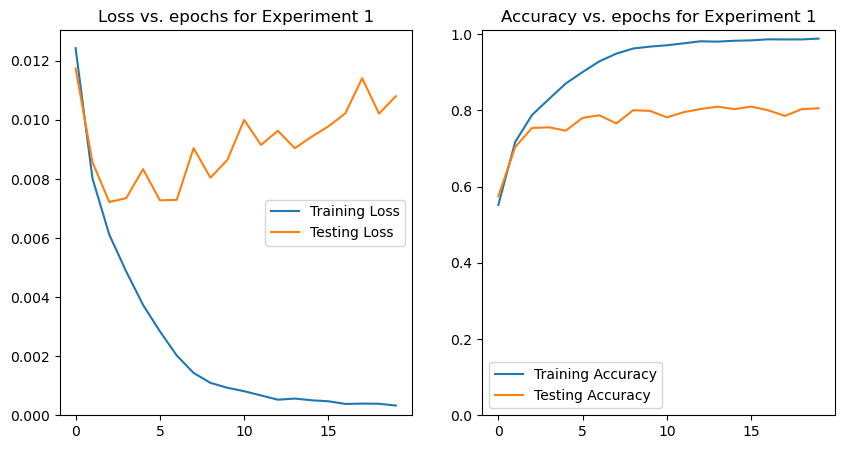

In [5]:

#Experiment 1

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform1,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []

# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 1')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 1')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0121, Testing Loss: 0.0106, Training Acc: 0.5653, Testing Acc: 0.6316
Epoch [2/20], Training Loss: 0.0079, Testing Loss: 0.0088, Training Acc: 0.7238, Testing Acc: 0.7011
Epoch [3/20], Training Loss: 0.0060, Testing Loss: 0.0084, Training Acc: 0.7915, Testing Acc: 0.7238
Epoch [4/20], Training Loss: 0.0047, Testing Loss: 0.0093, Training Acc: 0.8362, Testing Acc: 0.6995
Epoch [5/20], Training Loss: 0.0036, Testing Loss: 0.0078, Training Acc: 0.8743, Testing Acc: 0.7496
Epoch [6/20], Training Loss: 0.0027, Testing Loss: 0.0064, Training Acc: 0.9073, Testing Acc: 0.8020
Epoch [7/20], Training Loss: 0.0020, Testing Loss: 0.0073, Training Acc: 0.9313, Testing Acc: 0.7914
Epoch [8/20], Training Loss: 0.0014, Testing Loss: 0.0084, Training Acc: 0.9507, Testing Acc: 0.7819
Epoch [9/20], Training Loss: 0.0011, Testing Loss: 0.0089, Training Acc: 0.9622, Testing Acc: 0.7813
Epoch [10/20], Training Loss: 0.0009, Testing Loss: 0

(0.0, 1.010439)

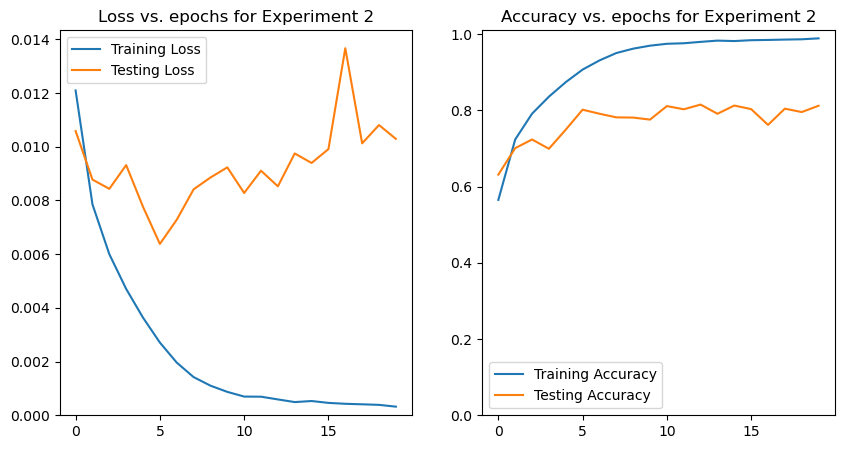

In [6]:

#Experiment 2

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform2,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 2')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 2')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0118, Testing Loss: 0.0229, Training Acc: 0.5777, Testing Acc: 0.3245
Epoch [2/20], Training Loss: 0.0075, Testing Loss: 0.0224, Training Acc: 0.7381, Testing Acc: 0.3384
Epoch [3/20], Training Loss: 0.0058, Testing Loss: 0.0168, Training Acc: 0.7982, Testing Acc: 0.4931
Epoch [4/20], Training Loss: 0.0045, Testing Loss: 0.0161, Training Acc: 0.8413, Testing Acc: 0.4917
Epoch [5/20], Training Loss: 0.0035, Testing Loss: 0.0179, Training Acc: 0.8788, Testing Acc: 0.4858
Epoch [6/20], Training Loss: 0.0026, Testing Loss: 0.0162, Training Acc: 0.9085, Testing Acc: 0.5488
Epoch [7/20], Training Loss: 0.0019, Testing Loss: 0.0199, Training Acc: 0.9333, Testing Acc: 0.4713
Epoch [8/20], Training Loss: 0.0014, Testing Loss: 0.0162, Training Acc: 0.9525, Testing Acc: 0.5723
Epoch [9/20], Training Loss: 0.0011, Testing Loss: 0.0240, Training Acc: 0.9627, Testing Acc: 0.4638
Epoch [10/20], Training Loss: 0.0008, Testing Loss: 0

(0.0, 1.0227709999999999)

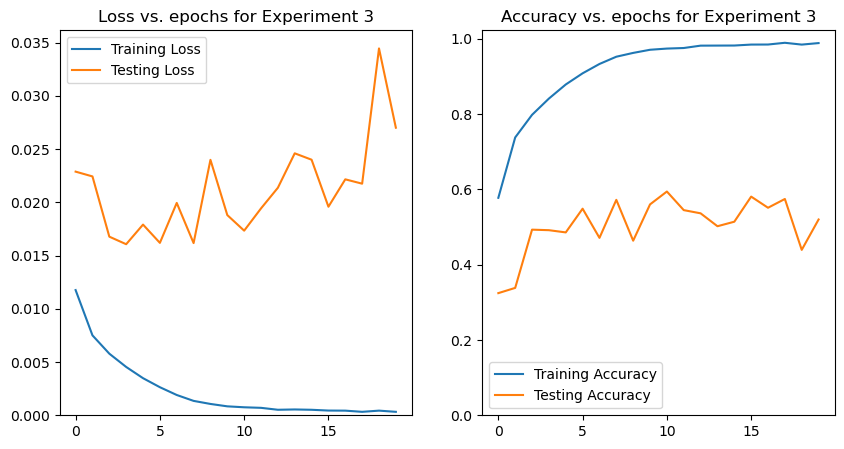

In [7]:

#Experiment 3

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform5,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 3')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 3')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0122, Testing Loss: 0.0118, Training Acc: 0.5628, Testing Acc: 0.5819
Epoch [2/20], Training Loss: 0.0079, Testing Loss: 0.0104, Training Acc: 0.7255, Testing Acc: 0.6515
Epoch [3/20], Training Loss: 0.0063, Testing Loss: 0.0076, Training Acc: 0.7791, Testing Acc: 0.7412
Epoch [4/20], Training Loss: 0.0053, Testing Loss: 0.0100, Training Acc: 0.8146, Testing Acc: 0.6707
Epoch [5/20], Training Loss: 0.0045, Testing Loss: 0.0061, Training Acc: 0.8416, Testing Acc: 0.7993
Epoch [6/20], Training Loss: 0.0039, Testing Loss: 0.0055, Training Acc: 0.8624, Testing Acc: 0.8180
Epoch [7/20], Training Loss: 0.0034, Testing Loss: 0.0060, Training Acc: 0.8821, Testing Acc: 0.8069
Epoch [8/20], Training Loss: 0.0029, Testing Loss: 0.0060, Training Acc: 0.9003, Testing Acc: 0.8053
Epoch [9/20], Training Loss: 0.0025, Testing Loss: 0.0056, Training Acc: 0.9137, Testing Acc: 0.8203
Epoch [10/20], Training Loss: 0.0021, Testing Loss: 0

(0.0, 0.998906)

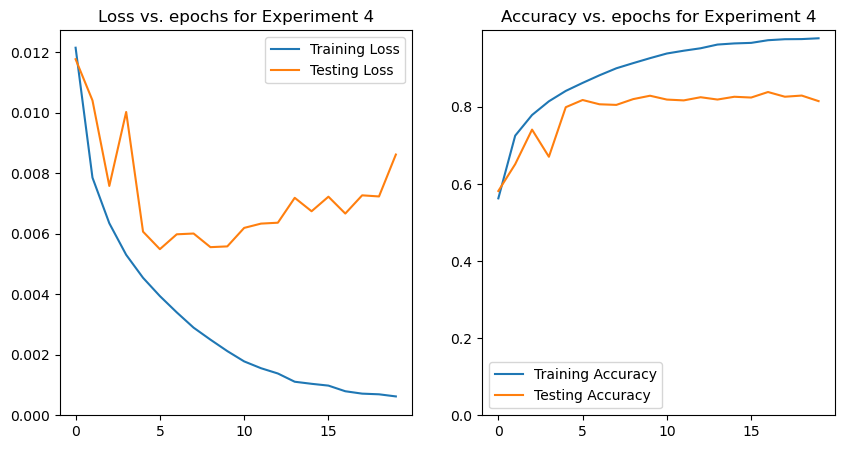

In [8]:

#Experiment 4

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform3,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 4')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 4')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0127, Testing Loss: 0.0280, Training Acc: 0.5395, Testing Acc: 0.1694
Epoch [2/20], Training Loss: 0.0084, Testing Loss: 0.0265, Training Acc: 0.7046, Testing Acc: 0.2334
Epoch [3/20], Training Loss: 0.0066, Testing Loss: 0.0223, Training Acc: 0.7710, Testing Acc: 0.3099
Epoch [4/20], Training Loss: 0.0052, Testing Loss: 0.0196, Training Acc: 0.8168, Testing Acc: 0.3766
Epoch [5/20], Training Loss: 0.0042, Testing Loss: 0.0297, Training Acc: 0.8549, Testing Acc: 0.3035
Epoch [6/20], Training Loss: 0.0032, Testing Loss: 0.0280, Training Acc: 0.8880, Testing Acc: 0.2969
Epoch [7/20], Training Loss: 0.0024, Testing Loss: 0.0200, Training Acc: 0.9152, Testing Acc: 0.4224
Epoch [8/20], Training Loss: 0.0018, Testing Loss: 0.0241, Training Acc: 0.9363, Testing Acc: 0.3720
Epoch [9/20], Training Loss: 0.0014, Testing Loss: 0.0264, Training Acc: 0.9504, Testing Acc: 0.3860
Epoch [10/20], Training Loss: 0.0010, Testing Loss: 0

(0.0, 1.0281740000000001)

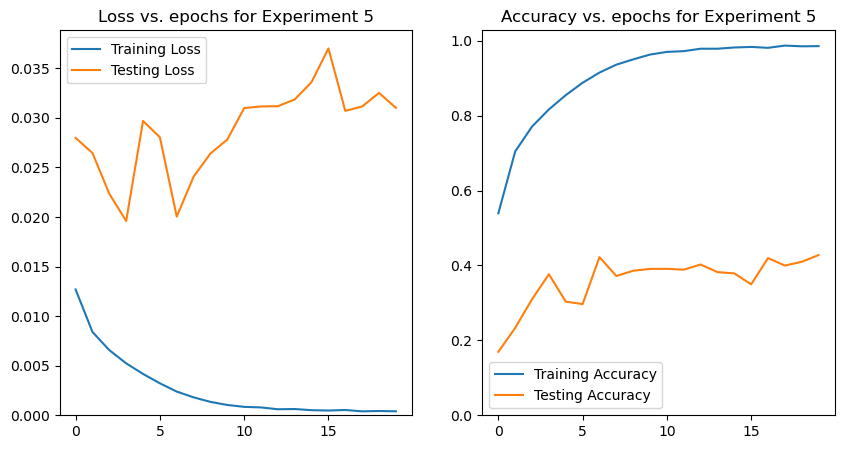

In [18]:

#Experiment 5

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform6,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 5')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 5')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0124, Testing Loss: 0.0272, Training Acc: 0.5548, Testing Acc: 0.1995
Epoch [2/20], Training Loss: 0.0082, Testing Loss: 0.0271, Training Acc: 0.7147, Testing Acc: 0.2295
Epoch [3/20], Training Loss: 0.0065, Testing Loss: 0.0251, Training Acc: 0.7748, Testing Acc: 0.2319
Epoch [4/20], Training Loss: 0.0055, Testing Loss: 0.0315, Training Acc: 0.8075, Testing Acc: 0.1892
Epoch [5/20], Training Loss: 0.0047, Testing Loss: 0.0207, Training Acc: 0.8359, Testing Acc: 0.3194
Epoch [6/20], Training Loss: 0.0041, Testing Loss: 0.0233, Training Acc: 0.8593, Testing Acc: 0.3241
Epoch [7/20], Training Loss: 0.0035, Testing Loss: 0.0211, Training Acc: 0.8798, Testing Acc: 0.3259
Epoch [8/20], Training Loss: 0.0030, Testing Loss: 0.0217, Training Acc: 0.8956, Testing Acc: 0.3241
Epoch [9/20], Training Loss: 0.0026, Testing Loss: 0.0226, Training Acc: 0.9100, Testing Acc: 0.3165
Epoch [10/20], Training Loss: 0.0022, Testing Loss: 0

(0.0, 1.015025)

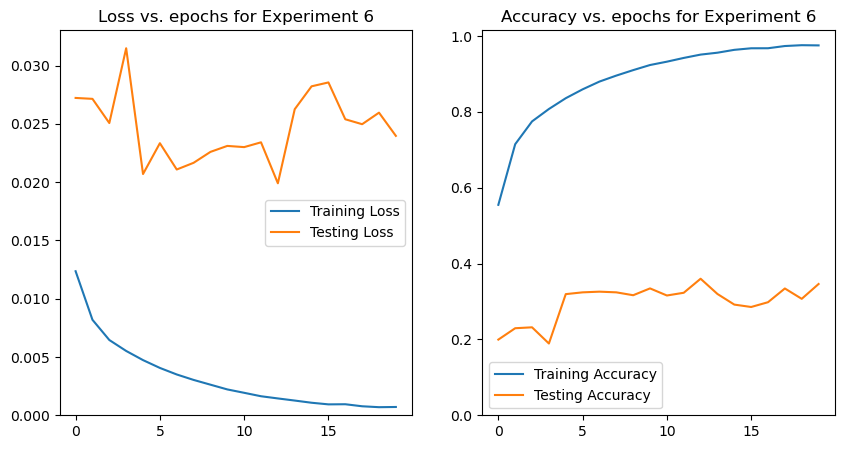

In [23]:

#Experiment 6

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 0

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform4,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 6')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 6')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0124, Testing Loss: 0.0296, Training Acc: 0.5532, Testing Acc: 0.1847
Epoch [2/20], Training Loss: 0.0083, Testing Loss: 0.0274, Training Acc: 0.7076, Testing Acc: 0.2213
Epoch [3/20], Training Loss: 0.0066, Testing Loss: 0.0269, Training Acc: 0.7699, Testing Acc: 0.2649
Epoch [4/20], Training Loss: 0.0056, Testing Loss: 0.0245, Training Acc: 0.8038, Testing Acc: 0.2779
Epoch [5/20], Training Loss: 0.0049, Testing Loss: 0.0274, Training Acc: 0.8309, Testing Acc: 0.2223
Epoch [6/20], Training Loss: 0.0042, Testing Loss: 0.0260, Training Acc: 0.8534, Testing Acc: 0.2707
Epoch [7/20], Training Loss: 0.0037, Testing Loss: 0.0228, Training Acc: 0.8712, Testing Acc: 0.3089
Epoch [8/20], Training Loss: 0.0032, Testing Loss: 0.0247, Training Acc: 0.8866, Testing Acc: 0.2963
Epoch [9/20], Training Loss: 0.0028, Testing Loss: 0.0207, Training Acc: 0.9036, Testing Acc: 0.3672
Epoch [10/20], Training Loss: 0.0024, Testing Loss: 0

(0.0, 1.010693)

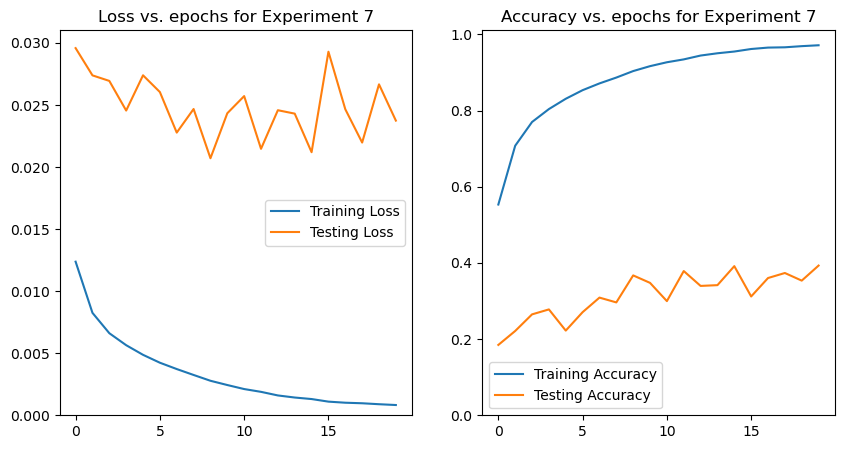

In [24]:

#Experiment 7

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.001
regularisation_weightdecay = 01e-5

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform4,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 7')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 7')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()


plt.plot(epochs_axis, losses5, Label="Training Loss")
plt.plot(epochs_axis, losses5_test, Label="Testing Loss")
plt.legend

Files already downloaded and verified
Epoch [1/20], Training Loss: 0.0163, Testing Loss: 0.0221, Training Acc: 0.4044, Testing Acc: 0.2158
Epoch [2/20], Training Loss: 0.0112, Testing Loss: 0.0227, Training Acc: 0.6004, Testing Acc: 0.2291
Epoch [3/20], Training Loss: 0.0092, Testing Loss: 0.0345, Training Acc: 0.6765, Testing Acc: 0.2121
Epoch [4/20], Training Loss: 0.0079, Testing Loss: 0.0443, Training Acc: 0.7250, Testing Acc: 0.1803
Epoch [5/20], Training Loss: 0.0070, Testing Loss: 0.0302, Training Acc: 0.7544, Testing Acc: 0.2190
Epoch [6/20], Training Loss: 0.0063, Testing Loss: 0.0268, Training Acc: 0.7803, Testing Acc: 0.2868
Epoch [7/20], Training Loss: 0.0059, Testing Loss: 0.0370, Training Acc: 0.7964, Testing Acc: 0.2437
Epoch [8/20], Training Loss: 0.0055, Testing Loss: 0.0255, Training Acc: 0.8083, Testing Acc: 0.3178
Epoch [9/20], Training Loss: 0.0052, Testing Loss: 0.0282, Training Acc: 0.8216, Testing Acc: 0.2720
Epoch [10/20], Training Loss: 0.0050, Testing Loss: 0

(0.0, 0.914628)

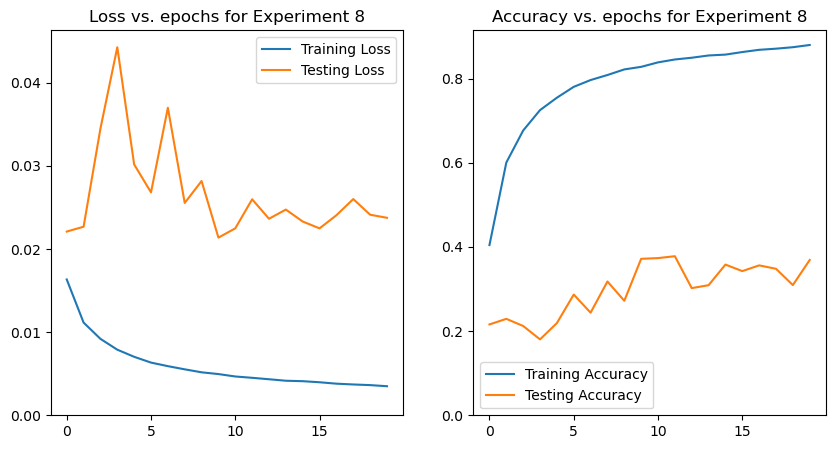

In [25]:

#Experiment 8

# Hyper-parameters
epochs = 20
batchSize = 100
learningRate = 0.01
regularisation_weightdecay = 01e-5

# download training and testing CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               transform=train_transform4,
                                               download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              transform=test_transform
                                              )

# load training and testing data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize,
                                          shuffle=False)


# Model instantiation
model = ResNet18(Block, [2, 2, 2,2]).to(device)

# Loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=regularisation_weightdecay)
losses_training = []
losses_testing = []
accuracy_training = []
accuracy_testing = []


# Training the model
for epoch in range(epochs):
    model.train()
    correct_training = 0
    total_training = 0
    running_loss_training = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        loss_training = criterion(outputs, labels)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss_training.backward()
        optimiser.step()

        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        running_loss_training += loss_training.item()

    #track performance
    losses_training.append(running_loss_training / total_training)
    accuracy_training.append(correct_training / total_training)

    # Testing the model
    model.eval()
    with torch.no_grad():
        correct_testing = 0
        total_testing = 0
        running_loss_testing = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss_testing = criterion(outputs, labels)
            
            total_testing += labels.size(0)
            correct_testing += (predicted == labels).sum().item()
            running_loss_testing += loss_testing.item()

    losses_testing.append(running_loss_testing / total_testing)
    accuracy_testing.append(correct_testing / total_testing)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss_training / total_training:.4f}, Testing Loss: {running_loss_testing / total_testing:.4f}, Training Acc: {correct_training / total_training:.4f}, Testing Acc: {correct_testing / total_testing:.4f}')

epochs_axis = range(len(losses_training))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs_axis, losses_training, label="Training Loss")
ax1.plot(epochs_axis, losses_testing, label="Testing Loss")
ax1.set_title('Loss vs. epochs for Experiment 8')
ax1.legend()
ax1.set_ylim(0, )
#plt.show()

ax2.plot(epochs_axis, accuracy_training, label="Training Accuracy")
ax2.plot(epochs_axis, accuracy_testing, label="Testing Accuracy")
ax2.set_title('Accuracy vs. epochs for Experiment 8')
ax2.legend()
ax2.set_ylim(0, )
#plt.show()
